# Health Inspection Scores for San Francisco Restaurants

Exploring the contents from a SQLite database containing health inspection scores for restaurants around San Francisco.  They take place between October 2013 to October 2015.

Source: [San Francisco Restaurant Health Inspections](http://2016.padjo.org/tutorials/sqlite-data-starterpacks/#toc-san-francisco-restaurant-health-inspections)

## Setting up

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# Creating a function that takes a SQL query as an argument
# and returns a pandas dataframe of that query. 

def run_query(q):
    with sqlite3.connect('sfscores.sqlite') as conn:
        return pd.read_sql(q, conn)
    
# Creating a function that takes a SQL command as an argument 
# and executes it using the sqlite module

def run_command(c):
    with sqlite3.connect('sfscores.sqlite') as conn:
        conn.isolation_level = None
        conn.execute(c)

# Creating a function that calls the run_query() function to return a 
# list of all tables and views in the database

def show_tables():
    st = "SELECT name, type FROM sqlite_master WHERE type IN (\"table\",\"view\");"
    return run_query(st)
    
show_tables()


,name,type
0,businesses,table
1,inspections,table
2,violations,table


In [ ]:
# Checking the content of businesses table

b_query = "SELECT * FROM businesses LIMIT 5"

run_query(b_query)

In [ ]:
# Checking the content of inspections table

i_query = "SELECT * FROM inspections LIMIT 5"

run_query(i_query)

In [ ]:
# Checking the content of violations table

v_query = "SELECT * FROM violations LIMIT 5"

run_query(v_query)

## Exploratory queries

Acquiring insights from the inspection reports

In [ ]:
# Returning the top 20 restaurants with the most violations

top20_violations_query = """

SELECT b.name, b.address, COUNT(1) num_violations
FROM businesses b
INNER JOIN violations v ON b.business_id = v.business_id
GROUP BY b.business_id
ORDER BY num_violations DESC
LIMIT 20
"""

run_query(top20_violations_query)

In [ ]:
# Returning the top 20 locations with the most violations per inspection

top20_avg_violations_query = """

WITH total_violations as (
    SELECT b.business_id, COUNT(1) num_violations
    FROM businesses b
    INNER JOIN violations v ON b.business_id = v.business_id
    GROUP BY b.business_id
), total_inspections as (
    SELECT b.business_id, COUNT(1) num_inspections
    FROM businesses b
    INNER JOIN inspections i ON b.business_id = i.business_id
    GROUP BY b.business_id
)

SELECT b.business_id, b.name, b.address, ROUND((CAST(tv.num_violations as Float)/CAST(ti.num_inspections
                     as float)), 2) avg_violations
FROM businesses b
INNER JOIN total_violations tv ON b.business_id = tv.business_id
INNER JOIN total_inspections ti ON b.business_id = ti.business_id
GROUP BY b.business_id
ORDER BY avg_violations DESC
LIMIT 20
"""

run_query(top20_avg_violations_query)

In [49]:
# Returning the number of violations per Month-Year combination

new_violations = """

CREATE TABLE IF NOT EXISTS violations_dates (
business_id TEXT, year_month TEXT, date TEXT, ViolationTypeID TEXT, risk_category TEXT, description TEXT
);

"""

insert_violations = """

INSERT INTO violations_dates
SELECT business_id, SUBSTR(date,1,6)|| '01', date, ViolationTypeID, risk_category, description
FROM violations;

"""

run_command(new_violations)
run_command(insert_violations)
run_command("DROP TABLE IF EXISTS violations;")
run_command("ALTER TABLE violations_dates RENAME TO violations;") 

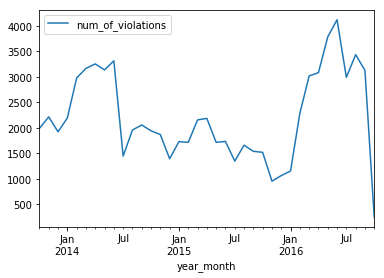

In [50]:
test_query = "SELECT * FROM inspection_dates LIMIT 15"

test_query2 = "PRAGMA table_info(violations);"

test_query3 = """

SELECT year_month, COUNT(1) num_of_violations
FROM violations
GROUP BY year_month
ORDER BY year_month

"""

violations_month = run_query(test_query3)
violations_month['year_month'] = pd.to_datetime(violations_month['year_month'], yearfirst=True)
violations_month.plot.line(x='year_month',y='num_of_violations')

In [33]:
# Dropping new tables to reset the sqlite database

run_command("DROP TABLE IF EXISTS chains;") 
run_command("DROP TABLE IF EXISTS violations_dates;") 


In [19]:
# Creating a table to the businesses table indicating whether or not a business is a chain.
# In this case, a chain is defined as a business with 3 or more locations.

create_chain = """

CREATE TABLE IF NOT EXISTS chains (
name TEXT, num_locations INTEGER,
PRIMARY KEY (name)
);

"""

insert_chain = """

INSERT INTO chains (name, num_locations)

SELECT b.name, COUNT(1) num_loc
FROM businesses b
GROUP BY b.name
HAVING num_loc > 2

"""

run_command(create_chain)
run_command(insert_chain)

run_query("SELECT * FROM chains ORDER BY num_locations DESC LIMIT 10")

,name,num_locations
0,Peet's Coffee & Tea,20
1,Starbucks Coffee,15
2,McDonald's,9
3,STARBUCKS,9
4,San Francisco Soup Company,9
5,Specialty's Cafe & Bakery,9
6,AT&T PARK - Food Cart,8
7,Jamba Juice,8
8,Subway Sandwiches,8
9,Bon Appetit @ Twitter,7
